# DL2023 Assignment 2 [Iñaky Ordiales]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import cv2 # pip install opencv-python

In [2]:
#A method to convert the class id to class name
id2name = {0:"speed_30", 1:"speed_50", 2:"speed_80", 3:"no_entry", 4:"stop", 5:"road_work", 6:"no_sign"}

def class_id2class_name(class_id):
    assert class_id in [0, 1, 2, 3, 4, 5, 6]
    return id2name[class_id]

In [3]:
# Selectinf a device to use.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are using {}".format(device))

We are using cpu


# 1. Train a convolutional neural network for multi-class classification
Your network will learn to classify 64x64 patches into one of the 7 classes: either one of the 6 traffic sign classes ("speed_30", "speed_50", "speed_80",  "no_entry", "stop", "road_work") or "no_sign". Instructions in the pdf.

#### Creating datasets and dataloaders
To be able to train our model we first had to open and read the images from their local folder and then make them a dataset. For this we used the ImageFolder function and the class we previously defined in some tutorial for transforming them into tensors and having them in RAM memory. The training set needed shuffle so that the model does not learned biased, but the validation set does not needs shuffle.

In [4]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose, ToPILImage, functional
from torch.utils.data import DataLoader


root_dir_train = 'data/train'
root_dir_valid = 'data/val'

transforms = Compose([ToTensor()])           # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)

train_dataset_ = ImageFolder(
  root_dir_train,
  is_valid_file=lambda x: x.endswith("png"))

valid_dataset_ = ImageFolder(
  root_dir_valid,
  is_valid_file=lambda x: x.endswith("png"))


class RAMDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        data = []
        for sample in tqdm(dataset):
            data.append(sample)
        self.n = len(data)
        self.data = data
        self.transform = transform
        
    def __getitem__(self, ind):
        if self.transform is not None:
            return self.transform(self.data[ind][0]), self.data[ind][1]
        else:
            return self.data[ind]
    
    def set_tranform(self, transform):
        self.transform = transform
    
    def __len__(self):
        return self.n


train_dataset = RAMDatasetWrapper(train_dataset_, transform=transforms)
valid_dataset = RAMDatasetWrapper(valid_dataset_, transform=transforms)

own_batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=own_batch_size, shuffle=True,  num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=own_batch_size, shuffle=False, num_workers=4)


100%|███████████████████████████████████████| 141/141 [00:00<00:00, 2267.71it/s]


#### Visualizing some few images of each class
Taking advantage of the fact that in the dataset we know that the images are ordered by their class number in groups of 200, we are able to show 3 images randomly selected from each class. 

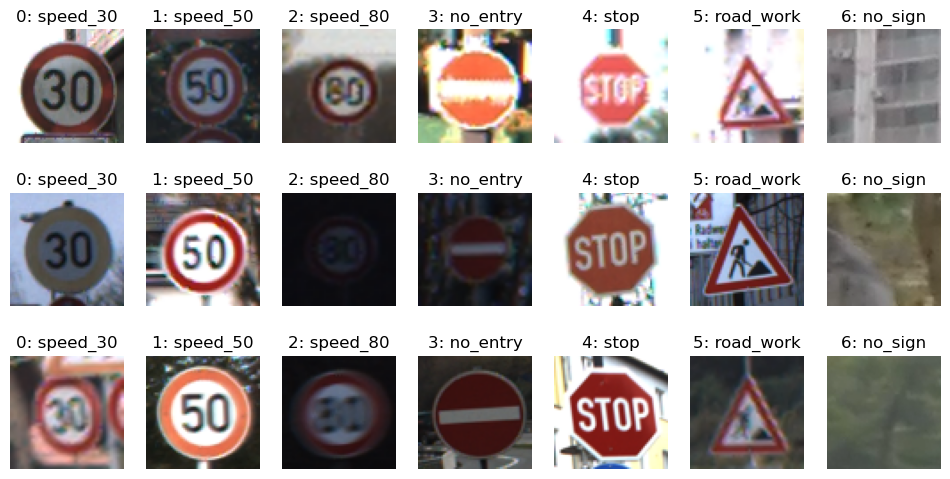

In [5]:

fig = plt.figure(figsize=(12, 6))
columns = 7
rows = 3
for i in range(0, columns*rows):
    index = (i%7)*200+np.random.randint(0,199)
    img = train_dataset[index][0].permute(1,2,0).cpu().numpy()
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
    label = train_dataset[index][1]
    plt.title(str(label)+": "+class_id2class_name(label))

plt.show()


#### Model definition
For the creation of the model we used a fully convolutional neural network as specified in the pdf assignment instructions:

       * Convolutional, kernel 3x3, stride 1, 32 channels.
       * Max Pooling, kernel 3x3, stride 2, ceil = True.
       * Activation LeakyReLU, slope 0.2.
       * Convolutional, kernel 3x3, stride 1, 64 channels.
       * Max Pooling, kernel 3x3 stride 2.
       * Activation LeakyReLU, slope 0.2.
       * Convolutional, kernel 3x3, stride 1, 64 channels.
       * Max Pooling, kernel 2x2, stride 2.
       * Activation LeakyReLU, slope 0.2
       * Convolutional, kernel 2x2, stride 1, 128 channels.
       * Activation LeakyReLU, slope 0.2
       * Convolutional, kernel 3x3, stride 1, 256 channels.
       * Activation LeakyReLU, slope 0.2
       * Convolutional, kernel 3x3, stride 1, 256 channels.
       * Activation LeakyReLU, slope 0.2
       * Convolutional, kernel 1x1, stride 1, 7 (output) channels.
At the end we added an extra layer of Average Pooling with a step of 60 (for the second part of the assignment) that if there were extra features it reduced them to 1. Making our output of size: [num_batches, 7, 1, 1].

We can also see the calculation for the channel and features for an input image of 64x64 pixels that are the ones we trained with.

In [6]:

class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv_layers = nn.Sequential(
            # input size: 3 x 64 x 64
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            # intermediate output: 32 x 62 x 62
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            # intermediate output: 32 x 31 x 31
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            # intermediate output: 64 x 29 x 29
            nn.MaxPool2d(kernel_size=3, stride=2),
            # intermediate output: 64 x 14 x 14
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            # intermediate output: 64 x 12 x 12
            nn.MaxPool2d(kernel_size=2, stride=2),
            # intermediate output: 64 x 5 x 5
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1),
            # intermediate output: 128 x 4 x 4
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            # intermediate output: 256 x 2 x 2
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1),
            # intermediate output: 256 x 1 x 1
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=1, stride=1),
            # final output size: 7 x 1 x 1
            nn.AvgPool2d(1, stride=60)
        )
        
    def forward(self, input):
        output = self.conv_layers(input)
        return output

#### Functions to train the model
The next functions were adapted from previous tutorials and are responsible for training, evaluating and plotting the results of the model in two graphs. Won't be discussed farther because it was already covered on the previous exercise.

In [7]:
import numpy as np

def train(model, train_loader, optimizer, loss_fn):
    '''
    Trains the model for one epoch
    '''
    model.train()
    losses = []
    n_correct = 0
    for iteration, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        output = output.view(output.size(0), 7)
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        n_correct += torch.sum(output.argmax(1) == labels).item()
    accuracy = 100.0 * n_correct / len(train_loader.dataset)
    return np.mean(np.array(losses)), accuracy
 
    
def test(model, test_loader, loss_fn):
    '''
    Tests the model on data from test_loader
    '''
    model.eval()
    test_loss = 0
    n_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            output = output.view(output.size(0), 7)
            loss = loss_fn(output, labels)
            test_loss += loss.item()
            n_correct += torch.sum(output.argmax(1) == labels).item()
    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
    return average_loss, accuracy


def fit(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                          train_losses[-1],
                                                                                                          train_accuracies[-1],
                                                                                                          val_losses[-1],
                                                                                                          val_accuracies[-1]))
    return train_losses, train_accuracies, val_losses, val_accuracies


def plot(train_losses, val_losses, train_accuracies, val_accuracies, title):
    plt.figure()
    plt.plot(np.arange(len(train_losses)), train_losses)
    plt.plot(np.arange(len(val_losses)), val_losses)
    plt.legend(['train_loss', 'val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    plt.title('{}: Train/val loss'.format(title));

    plt.figure()
    plt.plot(np.arange(len(train_accuracies)), train_accuracies)
    plt.plot(np.arange(len(val_accuracies)), val_accuracies)
    plt.legend(['train_acc', 'val_acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('{}: Train/val accuracy'.format(title));


#### Model Training
To train the model we used the parameters specified in the assignment:
   - Train for 40 epochs with batch size of 16.
   - Optimize the cross entropy loss.
   - Use Adam optimizer with learning rate 3e-4=0.0003.

In [8]:
# Parameters
model_conv = ConvModel()
model_conv = model_conv.to(device)
n_epochs = 40
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.0003
optimizer = torch.optim.Adam(model_conv.parameters(), lr=learning_rate)

## Training
curves = fit(train_loader, valid_loader, model_conv, optimizer, loss_fn, n_epochs)

Epoch 1/40: train_loss: 1.7713, train_accuracy: 27.4286, val_loss: 1.6344, val_accuracy: 42.5532
Epoch 2/40: train_loss: 0.9412, train_accuracy: 63.0714, val_loss: 1.0195, val_accuracy: 63.8298
Epoch 3/40: train_loss: 0.5984, train_accuracy: 74.2857, val_loss: 0.7201, val_accuracy: 69.5035
Epoch 4/40: train_loss: 0.4780, train_accuracy: 80.0714, val_loss: 0.5705, val_accuracy: 72.3404
Epoch 5/40: train_loss: 0.4058, train_accuracy: 83.0714, val_loss: 0.3961, val_accuracy: 82.9787
Epoch 6/40: train_loss: 0.3517, train_accuracy: 85.6429, val_loss: 0.3208, val_accuracy: 90.7801
Epoch 7/40: train_loss: 0.2840, train_accuracy: 88.7143, val_loss: 0.2283, val_accuracy: 94.3262
Epoch 8/40: train_loss: 0.2039, train_accuracy: 93.2143, val_loss: 0.1961, val_accuracy: 95.0355
Epoch 9/40: train_loss: 0.1807, train_accuracy: 93.8571, val_loss: 0.2498, val_accuracy: 94.3262
Epoch 10/40: train_loss: 0.1169, train_accuracy: 96.2857, val_loss: 0.1297, val_accuracy: 97.8723
Epoch 11/40: train_loss: 0.07

#### Plotting the results

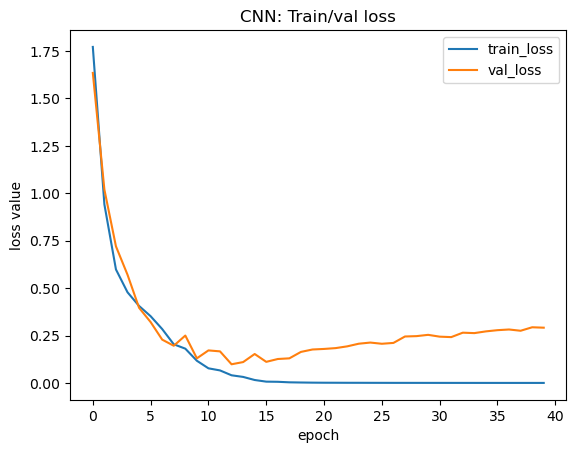

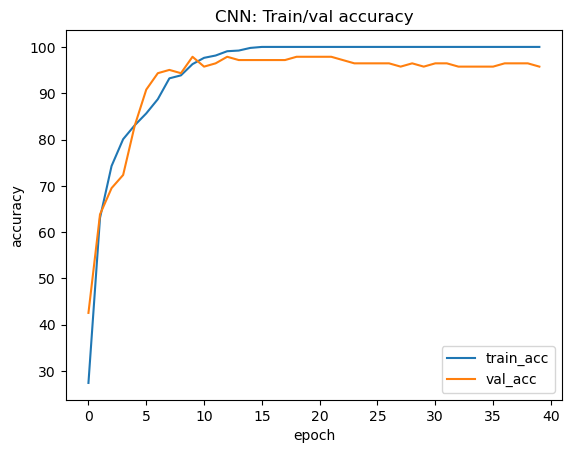

In [9]:
# Plotting
plot(curves[0], curves[2], curves[1], curves[3], title='CNN')


### Discussion of the results of training
At first sight the model seems to perform pretty well, with a validation accuracy of 97.16% we might thought that it is almost perfect. But in reality it is overfitting the training data with a 100% accuracy and also was trained for many more epochs than it needed. The final validation accuracy is not the biggest one through the epochs, around epoch 16-17 we got a val acc of 98.5816%. However I still think the model will perform well with new data.

# 2. Implement fully convolutional traffic sign detector that uses the multi-class classifier
Use your trained multi-class classification model for traffic sign detection in bigger images.  
Follow the instructions in the pdf and in the comments 

#### Filling in the missing code for the functions

#### detect_single_scale(...
Here were where the problems with the assignment began. At first our fully convolutional layer was able to take any size image as an input, but the output would not be of shape [batch, 7, 1, 1] until we added the last AvgDroop2d that make us loose accuracy and got a worst performance. Solving this, the other requirements were easy to implement, looking at the pytorch documentation and previous tutorials it was clear what was being asked and how to fulfill it. A set structure was used to avoid repeated values.

#### detect_multi_scale(...
Again it was clear what was being asked and the implementation was pretty straightforward, resizing the image, classifying it and then add to a corresponding list the name of the class.

In [10]:
class TrafficSignDetector:
    def __init__(self, model, scales=[1.0, 0.75, 0.5, 0.25], threshold=0.5):
        self.model = model
        self.scales = scales
        self.threshold = threshold
    
    @torch.no_grad()
    def detect_single_scale(self, image):
        '''Run a fully convolutional model on the input image'''
        '''Image is assumed to be of shape HxWx3 and scaled to [0,1]'''
        ## TODO
        ## Preprocess the image (as in training), convert the image to a tensor of shape 1x3xHxW; move it to the same device as the model
        image = ToTensor()(image)[0:3].unsqueeze(0)
        self.model = self.model.to(device)
        image = image.to(device)
    
        ## Run the self.model on the image 
        output = self.model(image)
    
        ## Process the output with softmax (torch.softmax) on the channel dimension
        output = torch.softmax(output, dim=1)
    
        ## Get the probabilities for the traffic sign classes (discard the non-traffic-sign class)
        output = output.squeeze(0)
        output = output[0:6]
        #print(output)
    
        ## Find the traffic sign classes where the probability > self.threshold
        detected_traffic_signs = set()
        for i in range(0,6):
            if (output[i]>self.threshold):
                detected_traffic_signs.add(i)    
      
        ## Return a set of the traffic signs that exist in the image
        ## if a traffic sign is found more than one time return it only once 
        return detected_traffic_signs
    
    @torch.no_grad()
    def detect_multi_scale(self, image):
        '''Run the detector on a pyramid of images (same image in different scales)'''
        detected_traffic_class = set()
        detected_traffic_signs = []
        H, W = image.size
        
        for scale_factor in self.scales:         
            ## TODO resize the image by scale_factor (e.g. cv2.resize, convert to PIL.Image and resize...)
            imageResized = image.resize((int(W*scale_factor), int(H*scale_factor)))
            
            ## Run detect_single_scale on resized image
            detected = self.detect_single_scale(imageResized)
            for num in detected:
                detected_traffic_class.add(num)
            
        for class_ in detected_traffic_class:
            detected_traffic_signs.append(class_id2class_name(class_))
        
        return detected_traffic_signs

Run evaluation on images from full_images folder; follow the instructions from the pdf

#### Evaluation with full images of different size
Here it was decided that the best way to show the results was to plot the image and a list of its signs on top of it. For this we added the images to a list and the analyze them with the detector (previously initialized with our model). The results were appended to an output list which finally displayed.

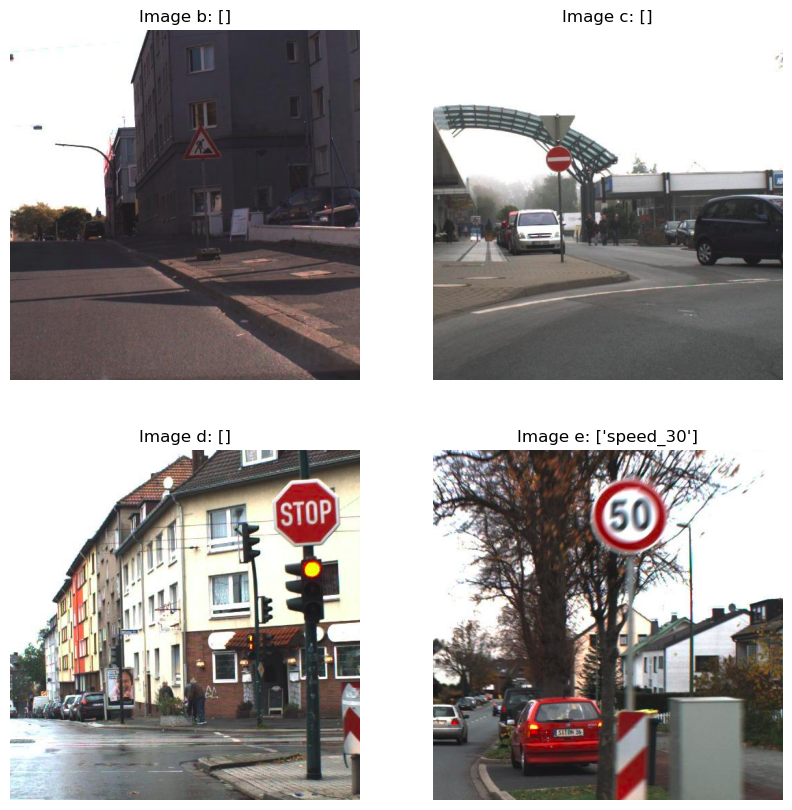

In [11]:

full_dir = 'data/full_images/'

img = []

img.append(Image.open(full_dir+"b.png"))
img.append(Image.open(full_dir+"c.png"))
img.append(Image.open(full_dir+"d.png"))
img.append(Image.open(full_dir+"e.png"))

detector = TrafficSignDetector(model_conv)

outputs = []
for idx, image in enumerate(img):
    outputs.append(detector.detect_multi_scale(image))

fig = plt.figure(figsize=(10, 10))
for i, image in enumerate(img):
    image = ToTensor()(image)
    image = image.permute(1,2,0).cpu().numpy()
    fig.add_subplot(2, 2, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Image "+chr(98+i)+": "+str(outputs[i]))
    
plt.show()

### Remarks of the results (disappointing and confused)
After running the detection on all four images only one detected any signs (image d) and even these results were wrongly interpreted by the model. In the other three the category wich always had a highest probability was no sign (discarded on the process).
This result was schocking and confusing, I reviewed several times my model and tried to tweak it for improvements, especially in the last average Pooling layer, but this was useless every time. I started thinking that this last layer with stride=60 was nonsense and messed up the model, but never found a way to work out the dimensions without it.
For a model with such high accuracy on the validation set then having 0 accuracy in this part was a disappointment.
In the next part some changes to the model tried to reverse this.

# 3. Improve your model
Propose different improvements and train new models (follow instructions from the pdf)

#### Avoiding over-fitting with dynamic early stop
One of the main suspitions of what affected the model was the overfitting and over training since really early it arrived to the 100% training accuracy. So to change this a new fit function is implemented which finishes the training if in 6 epochs there has been no improvement in the validation loss function and returns the model which did the best score in this metric.  

In [12]:
# New methode to train and avoid overfit.

from copy import deepcopy

def fit_new(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    best_val_loss = np.inf
    best_model = None
    patience = 6 # if no improvement after 6 epochs, stop training
    counter = 0
    for epoch in range(n_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                          train_losses[-1],
                                                                                                          train_accuracies[-1],
                                                                                                          val_losses[-1],
                                                                                                          val_accuracies[-1]))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(model)
            counter = 0 
        else:
            counter += 1
        if counter == patience:
            print('No improvement for {} epochs training stopped.'.format(patience))
            print('Returned model from epoch {} with best value loss of {}'.format(1+epoch-patience, best_val_loss))
            break
    
    return train_losses, train_accuracies, val_losses, val_accuracies, best_model

### New model 1
#### Same structure, change in the parameters, dynamic stopping

For the first refinement of the module there were not that many big changes, the structure of the neural network was kept the same, but the parameters changed and we used the dynamic stopping function.
The learning rate was decreased to see if these smaller steps helped the model converge better.

In [13]:
class ConvModel1(nn.Module):
    def __init__(self):
        super(ConvModel1, self).__init__()
        self.conv_layers = nn.Sequential(
            # input size: 3 x 64 x 64
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            # intermediate output: 32 x 62 x 62
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            # intermediate output: 32 x 31 x 31
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            # intermediate output: 64 x 29 x 29
            nn.MaxPool2d(kernel_size=3, stride=2),
            # intermediate output: 64 x 14 x 14
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            # intermediate output: 64 x 12 x 12
            nn.MaxPool2d(kernel_size=2, stride=2),
            # intermediate output: 64 x 5 x 5
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1),
            # intermediate output: 128 x 4 x 4
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            # intermediate output: 256 x 2 x 2
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1),
            # intermediate output: 256 x 1 x 1
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=1, stride=1),
            # final output size: 7 x 1 x 1
            nn.AvgPool2d(1, stride=60)
        )
        
    def forward(self, input):
        output = self.conv_layers(input)
        return output

Epoch 1/40: train_loss: 1.8940, train_accuracy: 19.2143, val_loss: 1.9660, val_accuracy: 28.3688
Epoch 2/40: train_loss: 1.4246, train_accuracy: 47.7857, val_loss: 1.4693, val_accuracy: 51.0638
Epoch 3/40: train_loss: 1.0308, train_accuracy: 60.7857, val_loss: 1.2148, val_accuracy: 58.1560
Epoch 4/40: train_loss: 0.9447, train_accuracy: 63.1429, val_loss: 1.3959, val_accuracy: 52.4823
Epoch 5/40: train_loss: 0.8106, train_accuracy: 69.3571, val_loss: 1.0328, val_accuracy: 64.5390
Epoch 6/40: train_loss: 0.6848, train_accuracy: 71.6429, val_loss: 0.7476, val_accuracy: 70.2128
Epoch 7/40: train_loss: 0.6124, train_accuracy: 75.5000, val_loss: 0.7265, val_accuracy: 73.7589
Epoch 8/40: train_loss: 0.5790, train_accuracy: 75.2143, val_loss: 0.5590, val_accuracy: 78.0142
Epoch 9/40: train_loss: 0.5017, train_accuracy: 77.2857, val_loss: 0.6339, val_accuracy: 71.6312
Epoch 10/40: train_loss: 0.4806, train_accuracy: 78.7857, val_loss: 0.5672, val_accuracy: 76.5957
Epoch 11/40: train_loss: 0.43

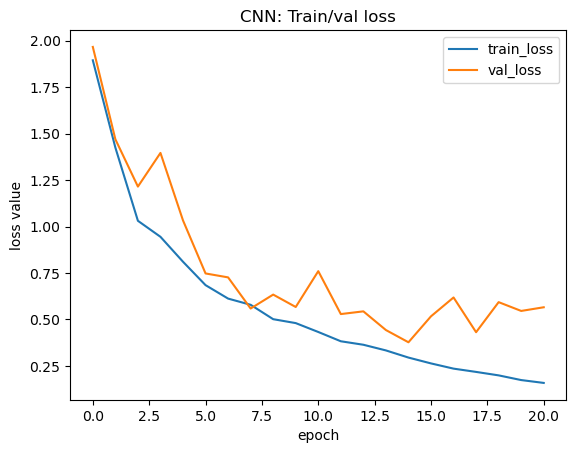

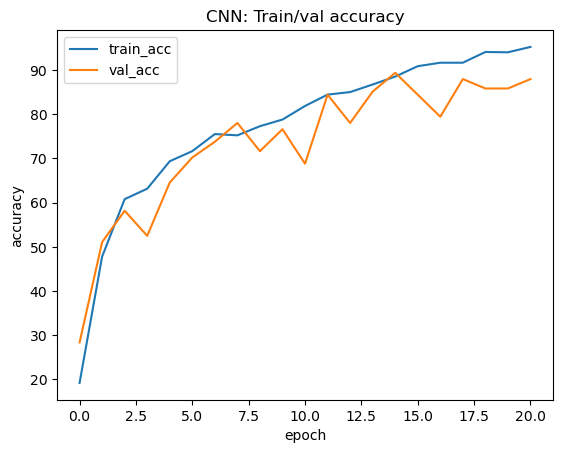

In [14]:
# Parameters
model_conv1 = ConvModel1()
model_conv1 = model_conv1.to(device)
n_epochs = 40
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model_conv1.parameters(), lr=learning_rate)

# Training
curves = fit_new(train_loader, valid_loader, model_conv1, optimizer, loss_fn, n_epochs)
model_conv1 = curves[4]

# Plotting
plot(curves[0], curves[2], curves[1], curves[3], title='CNN')

#### Results model 1:
Epoch 31/40: train_loss: 0.0430, train_accuracy: 98.8571, val_loss: 0.1152, val_accuracy: 97.1631

At the end we can see in the graph that for the validation set it keeps a tendency but is really shakey. The dynamic stopping gave us the 31st epoch with a validation accuracy of 97.1631 and training of 98.8571. This still feels a little overfitted. And the inestability of the validation is not too motivating.

### New model 2
#### Changing the MaxPool Layers with AvgPool and viceversa
Looking at the documentation I thought that maybe using an average pool instead of the max pool would have an interesting effect, so I switched them for this model. And also tried to do a manual early stopping with only 30 epochs instead of 40.

In [15]:
class ConvModel2(nn.Module):
    def __init__(self):
        super(ConvModel2, self).__init__()
        self.conv_layers = nn.Sequential(
            # input size: 3 x 64 x 64
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            # intermediate output: 32 x 62 x 62
            nn.AvgPool2d(kernel_size=3, stride=2, ceil_mode=True),
            # intermediate output: 32 x 31 x 31
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            # intermediate output: 64 x 29 x 29
            nn.AvgPool2d(kernel_size=3, stride=2),
            # intermediate output: 64 x 14 x 14
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            # intermediate output: 64 x 12 x 12
            nn.AvgPool2d(kernel_size=2, stride=2),
            # intermediate output: 64 x 5 x 5
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1),
            # intermediate output: 128 x 4 x 4
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            # intermediate output: 256 x 2 x 2
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1),
            # intermediate output: 256 x 1 x 1
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=1, stride=1),
            # final output size: 7 x 1 x 1
            nn.MaxPool2d(1, stride=60)
        )
        
    def forward(self, input):
        output = self.conv_layers(input)
        return output

Epoch 1/30: train_loss: 1.6930, train_accuracy: 30.2857, val_loss: 1.4920, val_accuracy: 37.5887
Epoch 2/30: train_loss: 0.9396, train_accuracy: 60.3571, val_loss: 0.5791, val_accuracy: 76.5957
Epoch 3/30: train_loss: 0.5655, train_accuracy: 75.7143, val_loss: 0.4449, val_accuracy: 82.2695
Epoch 4/30: train_loss: 0.4986, train_accuracy: 80.2143, val_loss: 0.3457, val_accuracy: 88.6525
Epoch 5/30: train_loss: 0.3788, train_accuracy: 84.3571, val_loss: 0.3651, val_accuracy: 87.2340
Epoch 6/30: train_loss: 0.3270, train_accuracy: 86.3571, val_loss: 0.3684, val_accuracy: 83.6879
Epoch 7/30: train_loss: 0.3391, train_accuracy: 85.7143, val_loss: 0.2929, val_accuracy: 90.0709
Epoch 8/30: train_loss: 0.2380, train_accuracy: 89.7143, val_loss: 0.3743, val_accuracy: 90.0709
Epoch 9/30: train_loss: 0.2306, train_accuracy: 91.1429, val_loss: 0.3889, val_accuracy: 87.2340
Epoch 10/30: train_loss: 0.1802, train_accuracy: 92.7857, val_loss: 0.2914, val_accuracy: 92.9078
Epoch 11/30: train_loss: 0.12

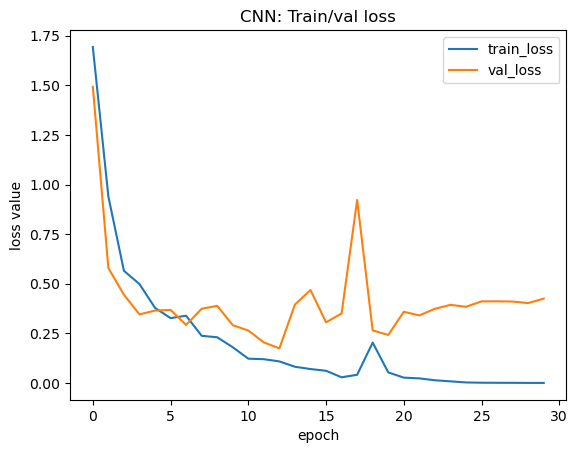

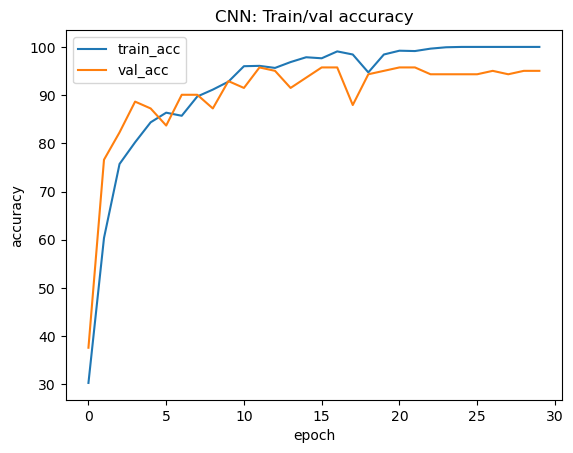

In [16]:
# Parameters

model_conv2 = ConvModel2()
model_conv2 = model_conv2.to(device)
n_epochs = 30
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.0003
optimizer = torch.optim.Adam(model_conv2.parameters(), lr=learning_rate)

# Training

curves = fit(train_loader, valid_loader, model_conv2, optimizer, loss_fn, n_epochs)

# Plotting

plot(curves[0], curves[2], curves[1], curves[3], title='CNN')

#### Results model 2:
Epoch 30/30: train_loss: 0.0015, train_accuracy: 100.0000, val_loss: 0.6678, val_accuracy: 95.0355

Also the validation set results seem unstable and the model seem to overfit with 100% the training but it got worse in the validation with only 95.0355. Does not seem like a good improvement

### New model 3
#### Using drop layers to reduce redundancy
For this last model the most important change is in the architecture, where we added some dropout layers with a probability of 0.5 before the last 3 convolutional layers respectively. Reducing some connections might help avoid overfitting and perform better in generalization. Also used only 30 epochs for training.

In [17]:
class ConvModel3(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(ConvModel3, self).__init__()
        self.conv_layers = nn.Sequential(
            # input size: 3 x 64 x 64
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            # intermediate output: 32 x 62 x 62
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            # intermediate output: 32 x 31 x 31
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            # intermediate output: 64 x 29 x 29
            nn.MaxPool2d(kernel_size=3, stride=2),
            # intermediate output: 64 x 14 x 14
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            # intermediate output: 64 x 12 x 12
            nn.MaxPool2d(kernel_size=2, stride=2),
            # intermediate output: 64 x 5 x 5
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1),
            # intermediate output: 128 x 4 x 4
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p), ### Adding dropout layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            # intermediate output: 256 x 2 x 2
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p), ### Adding dropout layer
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1),
            # intermediate output: 256 x 1 x 1
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p), ### Adding dropout layer
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=1, stride=1),
            # final output size: 7 x 1 x 1
            nn.AvgPool2d(1, stride=60)
        )
        
    def forward(self, input):
        output = self.conv_layers(input)
        return output

Epoch 1/30: train_loss: 1.8648, train_accuracy: 21.0000, val_loss: 1.7709, val_accuracy: 41.1348
Epoch 2/30: train_loss: 1.1410, train_accuracy: 55.1429, val_loss: 1.0135, val_accuracy: 65.9574
Epoch 3/30: train_loss: 0.7230, train_accuracy: 71.7857, val_loss: 0.7875, val_accuracy: 72.3404
Epoch 4/30: train_loss: 0.5789, train_accuracy: 77.0000, val_loss: 0.6038, val_accuracy: 79.4326
Epoch 5/30: train_loss: 0.4731, train_accuracy: 80.6429, val_loss: 0.5865, val_accuracy: 76.5957
Epoch 6/30: train_loss: 0.3825, train_accuracy: 83.1429, val_loss: 0.3446, val_accuracy: 88.6525
Epoch 7/30: train_loss: 0.3304, train_accuracy: 86.2143, val_loss: 0.2366, val_accuracy: 92.9078
Epoch 8/30: train_loss: 0.2486, train_accuracy: 90.0714, val_loss: 0.3698, val_accuracy: 90.7801
Epoch 9/30: train_loss: 0.2086, train_accuracy: 92.0000, val_loss: 0.2406, val_accuracy: 93.6170
Epoch 10/30: train_loss: 0.1909, train_accuracy: 93.9286, val_loss: 0.2339, val_accuracy: 94.3262
Epoch 11/30: train_loss: 0.17

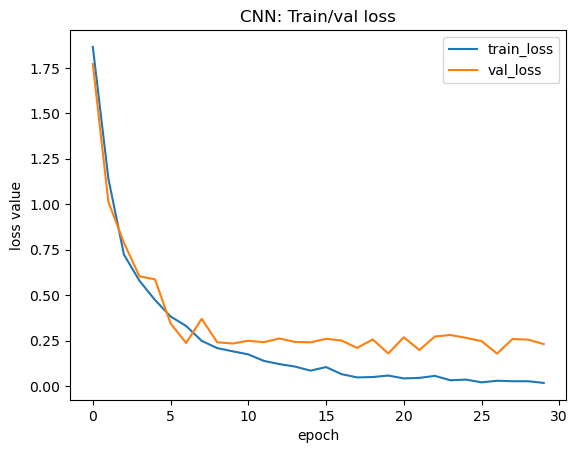

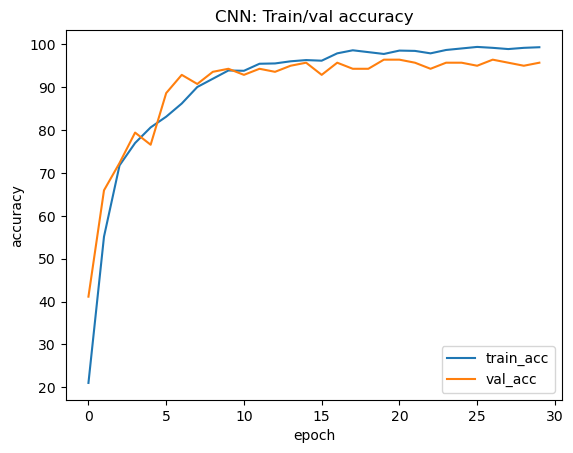

In [18]:
# Parameters

model_conv3 = ConvModel3()
model_conv3 = model_conv3.to(device)
n_epochs = 30
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.0003
optimizer = torch.optim.Adam(model_conv3.parameters(), lr=learning_rate)

# Training

curves = fit(train_loader, valid_loader, model_conv3, optimizer, loss_fn, n_epochs)

# Plotting

plot(curves[0], curves[2], curves[1], curves[3], title='CNN')

#### Results model 3:
Epoch 30/30: train_loss: 0.0260, train_accuracy: 99.1429, val_loss: 0.2659, val_accuracy: 96.4539

The train accuracy is really high, but also the validation accuracy is high enough, maybe it does generalize better and is an improvement from the previous ones. 

### Remarks of new models
The first new model outperformed the original model and the third one tied it. All this in terms of validation accuracy. Let's see if the detector improves

## Seeing the new models perform on the detection task:
To check if they perform better at detection we will try each of them.

#### New model 1 detection

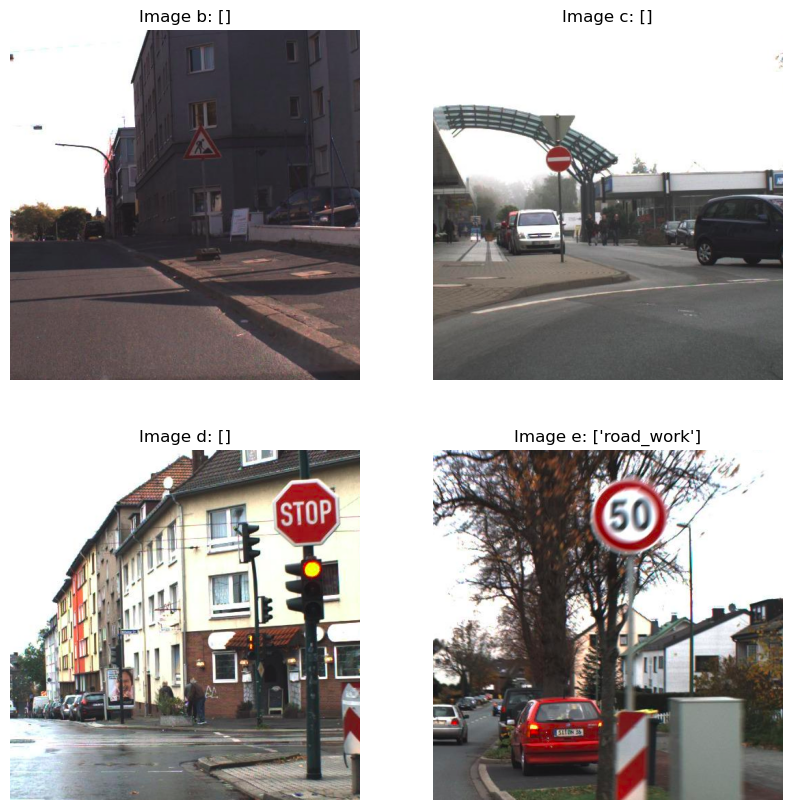

In [19]:
full_dir = 'data/full_images/'

img = []

img.append(Image.open(full_dir+"b.png"))
img.append(Image.open(full_dir+"c.png"))
img.append(Image.open(full_dir+"d.png"))
img.append(Image.open(full_dir+"e.png"))

detector = TrafficSignDetector(model_conv1)

outputs = []
for idx, image in enumerate(img):
    outputs.append(detector.detect_multi_scale(image))

fig = plt.figure(figsize=(10, 10))
for i, image in enumerate(img):
    image = ToTensor()(image)
    image = image.permute(1,2,0).cpu().numpy()
    fig.add_subplot(2, 2, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Image "+chr(98+i)+": "+str(outputs[i]))
    
plt.show()

#### New model 2 detection

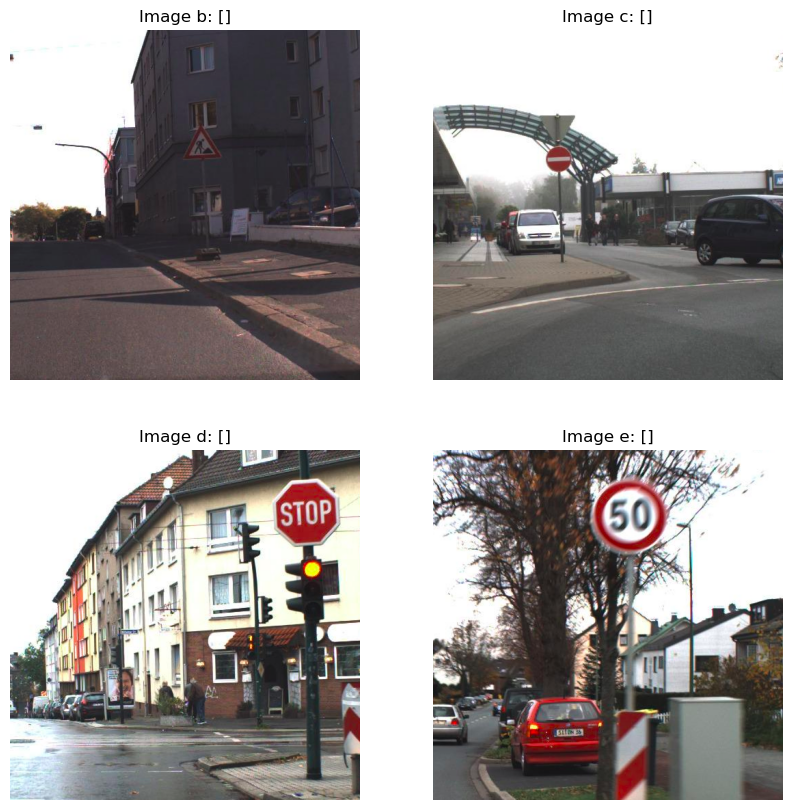

In [20]:
full_dir = 'data/full_images/'

img = []

img.append(Image.open(full_dir+"b.png"))
img.append(Image.open(full_dir+"c.png"))
img.append(Image.open(full_dir+"d.png"))
img.append(Image.open(full_dir+"e.png"))

detector = TrafficSignDetector(model_conv2)

outputs = []
for idx, image in enumerate(img):
    outputs.append(detector.detect_multi_scale(image))

fig = plt.figure(figsize=(10, 10))
for i, image in enumerate(img):
    image = ToTensor()(image)
    image = image.permute(1,2,0).cpu().numpy()
    fig.add_subplot(2, 2, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Image "+chr(98+i)+": "+str(outputs[i]))
    
plt.show()

#### New model 3 detection

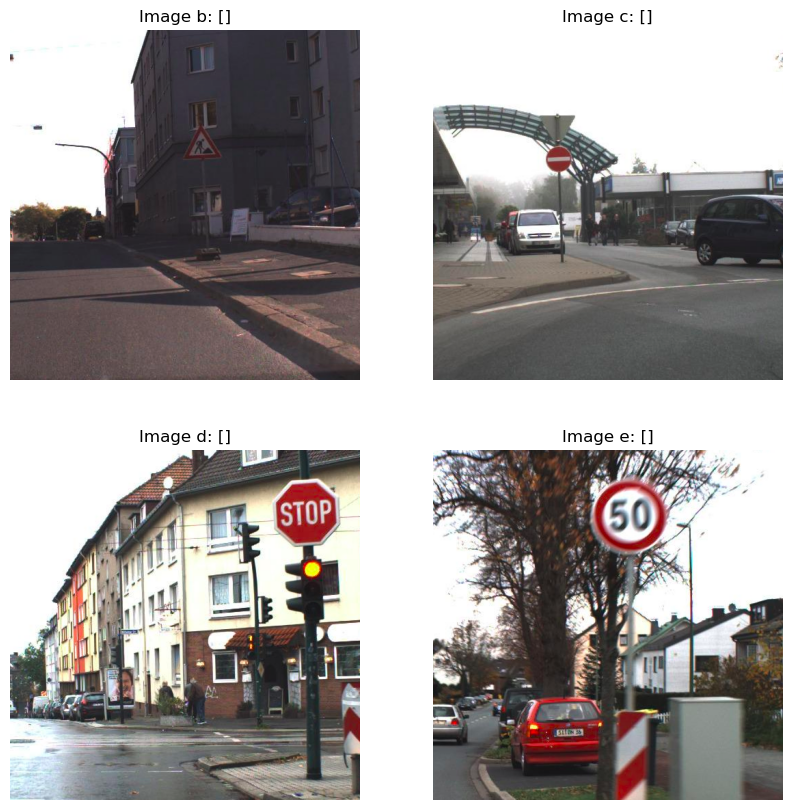

In [21]:
full_dir = 'data/full_images/'

img = []

img.append(Image.open(full_dir+"b.png"))
img.append(Image.open(full_dir+"c.png"))
img.append(Image.open(full_dir+"d.png"))
img.append(Image.open(full_dir+"e.png"))

detector = TrafficSignDetector(model_conv3)

outputs = []
for idx, image in enumerate(img):
    outputs.append(detector.detect_multi_scale(image))

fig = plt.figure(figsize=(10, 10))
for i, image in enumerate(img):
    image = ToTensor()(image)
    image = image.permute(1,2,0).cpu().numpy()
    fig.add_subplot(2, 2, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Image "+chr(98+i)+": "+str(outputs[i]))
    
plt.show()

### Final remarks:

With only one label produced by all three models and it being incorrect, the models failed to complete the detection task succesfully. I still think that is has to do with the last layer to deal with the dimensions of bigger pictures, but could not figure out how to fix it.
It was disappointing ending like this the assignment.